In [1]:
import tools.readingData as read
import dataLoader 
import models.vg16 
import tensorflow as tf
import random
import numpy as np

import metrics.custom_metrics as metric
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score,det_curve, precision_recall_curve
import matplotlib.pyplot as plt
import tools.readingData as read

2024-08-26 15:14:38.580924: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-26 15:14:38.613946: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-26 15:14:38.613971: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-26 15:14:38.614820: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-26 15:14:38.620104: I tensorflow/core/platform/cpu_feature_guar

In [2]:
def image_processing(image_path,image_size=(224,224)):
    image =tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image= tf.image.resize(image, image_size)
    image= tf.cast(image, tf.float32)/255.0 ### Making it O and 1
    return tf.expand_dims(image, axis=0)

In [3]:
def vgg_based_model(checkpoint_path):
    model_vgg = models.vg16.VGG16_Based(16,input_shape=(224,224,3))
    
    model_vgg.load_weights(checkpoint_path)
    return model_vgg

def create_pred_text(image_path_list, inf_model, thr=None):
    for idx,img_path in enumerate(image_path_list):
        _img=image_processing(img_path)
        print(idx)
        y_pred=inf_model(_img)
        y_pred_binary=tf.squeeze(tf.where(y_pred >= thr, 1.0, 0.0)).numpy()
        y_pred_prob=tf.squeeze(y_pred).numpy()
        with open("test_pred.txt", "+a") as f:
            f.write(f"{y_pred_binary}\n")

In [12]:
def predicated_img(image_path_list, inf_model, thr=0.5):
    for idx,img_path in enumerate(image_path_list):
        _img=image_processing(img_path)
        print(idx)
        y_pred=inf_model(_img)
        y_pred_binary=tf.squeeze(tf.where(y_pred >= thr, 1.0, 0.0)).numpy()
        y_pred_prob=tf.squeeze(y_pred).numpy()
        plt.subplot(5, 2, idx + 1)
        plt.imshow(tf.squeeze(_img))
    
        plt.title(f'Predicted: {y_pred_binary:.2f}, {y_pred_prob:.2f}', fontsize=7)
        plt.axis('off')
        plt.savefig("pictures/Prediction_image.png")

In [5]:

def get_yp_yt(val_dataset, inf_model):
    pred_list=[]
    true_list=[]
    for index, (x_train, y_true) in enumerate(val_dataset):
        y_pred =(inf_model((x_train)).numpy())
        pred_list.append(y_pred.flatten())
        true_list.append(tf.cast(y_true, dtype=tf.int32).numpy().flatten())
        print(index)
        if index>2500:
            break
    return np.array(pred_list).flatten(), np.array(true_list).flatten()

In [6]:

def plot_roc(Tr, Pr):
    fpr, tpr, thresholds = roc_curve(Tr, Pr, pos_label=1)
    ras=roc_auc_score(Tr, Pr)
    # print(thresholds)
    # print("fpr", fpr)
    # print("tpr", tpr)
    max_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[max_idx]

    plt.figure()
    plt.scatter(fpr, tpr, label=f'ROC-AUC: {ras:.2f}',marker='+',alpha=0.4, s=2)
    plt.plot(fpr[max_idx], tpr[max_idx], 'ro', label=f'Optimal Threshold: {optimal_threshold:.2f}')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.grid()
    plt.legend()
    plt.savefig("pictures/ROC_curve.png")

def plot_det(Tr, Pr):
    fpr, fnr, thresholds = det_curve(Tr, Pr, pos_label=1)
    max_idx = np.argmin(abs(fnr - fpr))
    optimal_threshold = thresholds[max_idx]

    plt.figure()
    plt.scatter(fpr, fnr, label=f'Detection curve',marker='+',alpha=0.4, s=2)
    plt.plot(fpr[max_idx], fnr[max_idx], 'ro', label=f'Optimal Threshold: {optimal_threshold:.2f}')
    plt.xlabel("FPR")
    plt.ylabel("FNR")
    plt.title("Detection curve")
    plt.grid()
    plt.legend()
    plt.savefig("pictures/DET_curve.png")

    HTER=(fnr+fpr)/2
    idx = np.argmin(HTER)
    plt.figure()
    plt.scatter(thresholds, (fnr+fpr)/2, label=f'Detection curve',marker='+',alpha=0.4, s=2)
    plt.plot(thresholds[idx], HTER[idx], 'ro', label=f'Optimal Threshold: {thresholds[idx]:.2f}')
    plt.xlabel("Threshold")
    plt.ylabel("HTER")
    plt.title("Detection curve")
    plt.grid()
    plt.legend()
    plt.savefig("pictures/HTER_curve.png")
    
def plot_PR(Tr, Pr):
    precision, recall, thresholds = precision_recall_curve(Tr, Pr, pos_label=1)
  
    max_idx = np.argmin(abs(recall-precision))
    optimal_threshold = thresholds[max_idx]

    plt.figure()
    plt.scatter(precision, recall, label=f'P-R',marker='+',alpha=0.4, s=2)
    plt.plot(precision[max_idx], recall[max_idx], 'ro', label=f'Optimal Threshold: {optimal_threshold:.2f}')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("precision-recall Curve")
    plt.grid()
    plt.legend()
    plt.savefig("pictures/PR-Recall_curve.png")
    
    F1= 2*((precision*recall)/(precision+recall))
    index_max=np.argmax(F1)
    
    plt.figure()
    plt.scatter(thresholds, F1[:-1], label=f'P-R',marker='+',alpha=0.4, s=2)
    plt.plot(thresholds[index_max], F1[index_max], 'ro', label=f'Optimal Threshold: {thresholds[index_max]:.2f}')
    plt.xlabel("Thresholds")
    plt.ylabel("F1")
    plt.title("F1 score Curve")
    plt.grid()
    plt.legend()
    plt.savefig("pictures/F1_Threshold_curve.png")

In [7]:
train_images_path=read.getTrainDataPathList( "data/train_img")
labels=read.getTrainLabels("data/label_train.txt")
Datasets_init=dataLoader.ImageDataLoader(train_images_path, labels, batch_size=8,image_size=(224,224),augument=False)
val_dataset =  Datasets_init.get_val_dataset()

2024-08-26 15:14:40.024342: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-26 15:14:40.051520: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-26 15:14:40.051690: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [8]:
checkpoint_path="checkpoint/checkpoint_20240826-111818/epoch_6.ckpt"#"checkpoint/checkpoint_20240825-172224/epoch_100.ckpt"
inf_model=vgg_based_model(checkpoint_path)
test_path = "data/val_img"

In [9]:
Pr, Tr=get_yp_yt(val_dataset, inf_model)

2024-08-26 15:14:42.622465: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-08-26 15:14:43.866142: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.47GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-08-26 15:14:45.149636: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.47GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

[[ 2207   213]
 [ 1471 16109]]


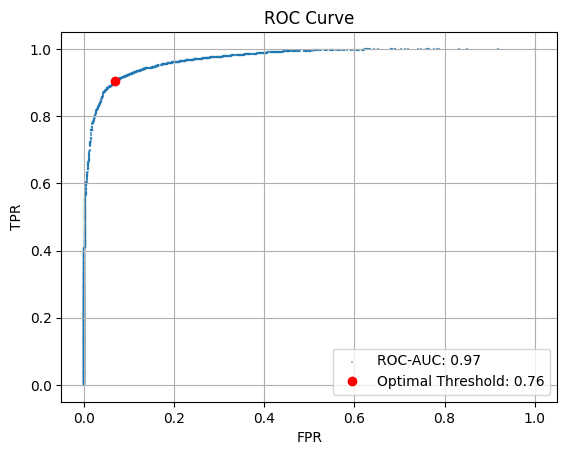

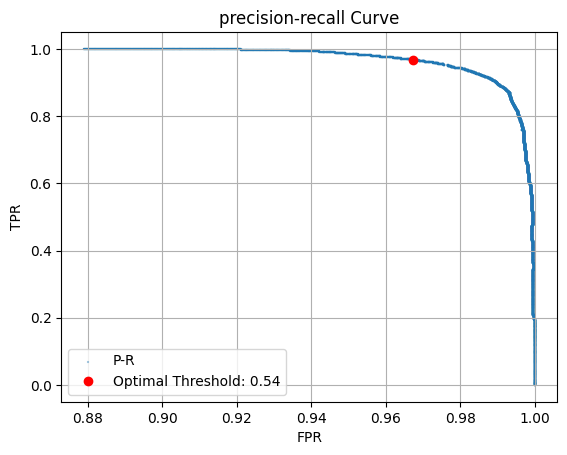

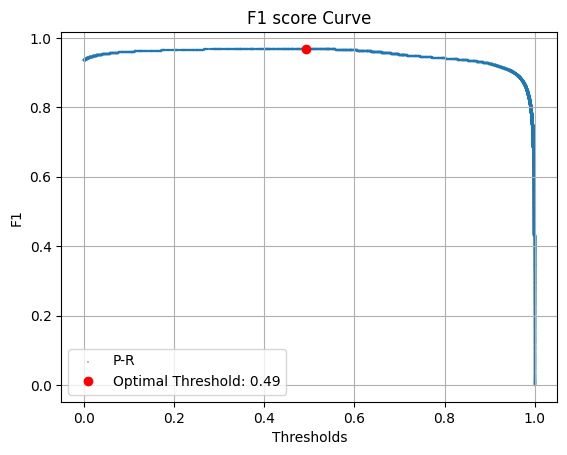

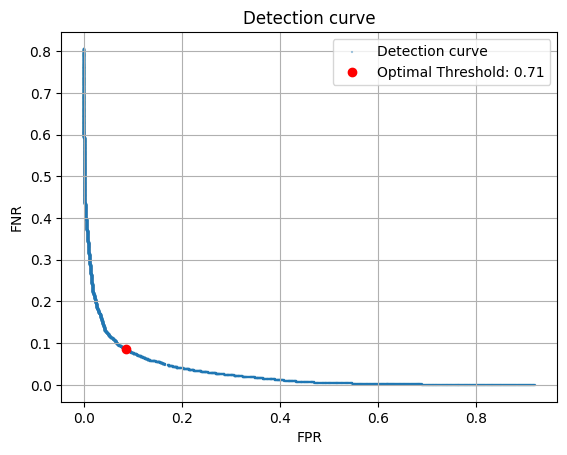

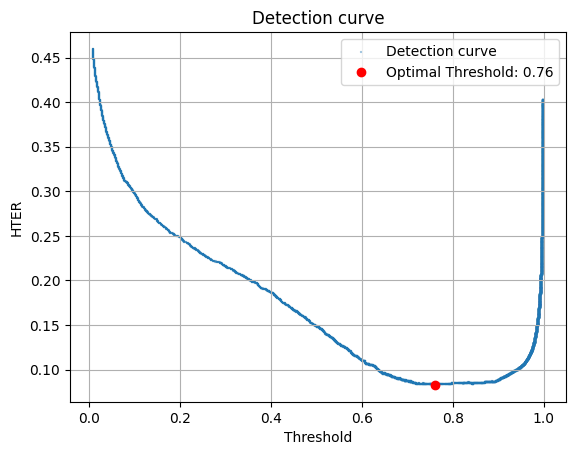

In [10]:
plot_roc(Tr, Pr) 
plot_PR(Tr, Pr)
plot_det(Tr, Pr)
cm = confusion_matrix(Tr, np.where(Pr >= 0.71, 1, 0))
print(cm)

0
1
2
3
4
5
6
7
8
9


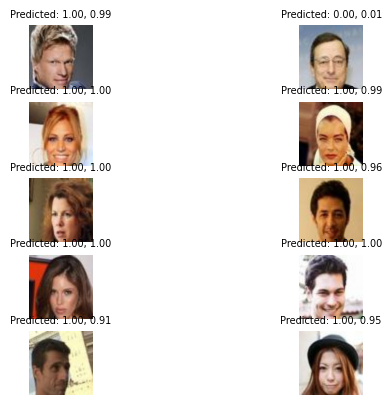

In [11]:
test_img_lists=random.sample(read.getTestDataPathList(test_path),10)#read.getTestDataPathList(test_path)#random.sample(read.getTestDataPathList(test_path),10)
    
predicated_img(test_img_lists, inf_model, thr=0.72)